# Dataset construction

In [12]:
import torch 
import numpy as np

np.random.seed(1328)
torch.random.manual_seed(1328)

In [13]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns


Train set: (1952, 3), Test set: (488, 3)


C:\Users\orazi\AppData\Local\Temp\ipykernel_9192\1844647450.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


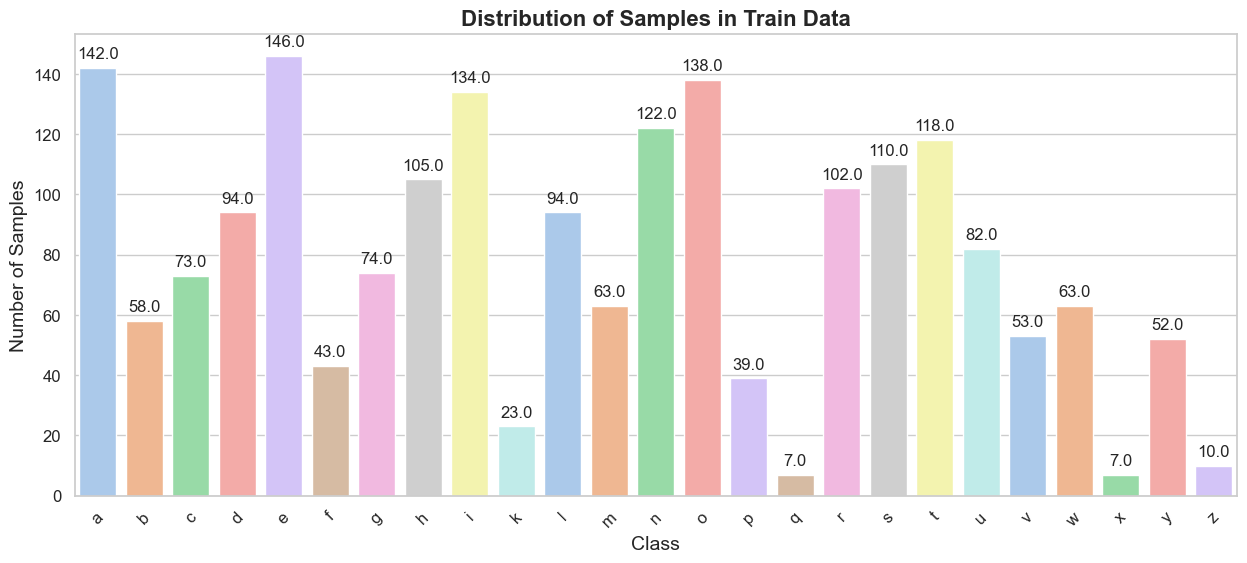

C:\Users\orazi\AppData\Local\Temp\ipykernel_9192\1844647450.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


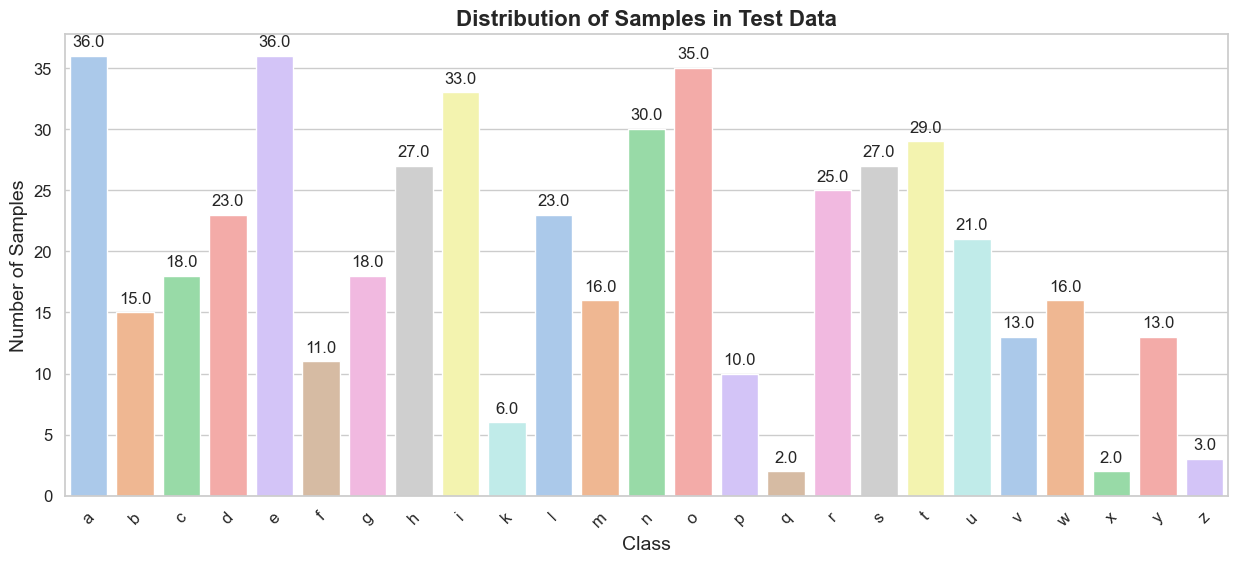

In [14]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

def load_images_from_subfolders(main_folder):
    data = []
    label_names = {}
    label_index = 0
    alphabet = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']  # List of characters excluding 'j'
    
    # Loop through each subject folder
    for subject_folder in os.listdir(main_folder):
        subject_path = os.path.join(main_folder, subject_folder)
        if os.path.isdir(subject_path):
            # Loop through each letter subfolder
            for letter_folder in os.listdir(subject_path):
                letter_path = os.path.join(subject_path, letter_folder)
                if os.path.isdir(letter_path):
                    # Get or create a label index for the letter
                    if letter_folder not in label_names:
                        label_names[letter_folder] = label_index
                        label_index += 1
                    label = label_names[letter_folder]
                    
                    # Load each image in the letter subfolder
                    for filename in os.listdir(letter_path):
                        img = cv2.imread(os.path.join(letter_path, filename), cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, (100, 100)) 
                            data.append({'image': img, 'label': label, 'letter': letter_folder})
    
    return pd.DataFrame(data), label_names, alphabet

def prepare_data(df):
    # Expand the dimensions of images to add the channel dimension
    df['image'] = df['image'].apply(lambda x: x[:, :, np.newaxis])
    
    # Convert labels to one-hot encoding
    labels = to_categorical(df['label'], num_classes=df['label'].nunique())
    df['label'] = list(labels)
    
    return df

def create_train_test_dataframe(df, test_size=0.2):
    # Split the dataset into training and testing sets
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=42, stratify=df['label'].apply(lambda x: np.argmax(x)))
    
    print(f"Train set: {df_train.shape}, Test set: {df_test.shape}")
    
    return df_train, df_test

def plot_class_distribution(df, title, alphabet):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 6))
    label_indices = df['label'].apply(lambda x: np.argmax(x))  # Get the original class indices
    label_counts = label_indices.value_counts().reindex(range(len(alphabet)), fill_value=0)
    
    ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)
    ax.set_title(f"Distribution of Samples in {title} Data", fontsize=16, fontweight='bold')
    ax.set_xlabel("Class", fontsize=14)
    ax.set_ylabel("Number of Samples", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'plots/distribution_{title}_data.png')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
    plt.show()

# Usage example
main_folder = 'dataset'
df, label_names, alphabet = load_images_from_subfolders(main_folder)
df = prepare_data(df)
df_train, df_test = create_train_test_dataframe(df)

plot_class_distribution(df_train, 'Train', alphabet)
plot_class_distribution(df_test, 'Test', alphabet)


In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

def plot_sample_images(df_train, alphabet):
    fig = plt.figure(figsize=(9, 9))
    gs = GridSpec(3, 3, figure=fig)  # Griglia 3x3

    # Convert one-hot encoded labels back to integers for uniqueness
    df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))
    unique_labels = df_train['label_int'].unique()[:3]  # Limita a 3 categorie

    for i, category in enumerate(unique_labels):
        sample_images = df_train[df_train['label_int'] == category].sample(min(3, len(df_train[df_train['label_int'] == category])))
        for j, (index, row) in enumerate(sample_images.iterrows()):
            ax = fig.add_subplot(gs[i, j])
            img = row['image'].reshape(100, 100)  # Assuming the images are 64x64
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.text(0.5, -0.1, alphabet[category], fontsize=25, color='black', ha='center', transform=ax.transAxes)
    plt.show()



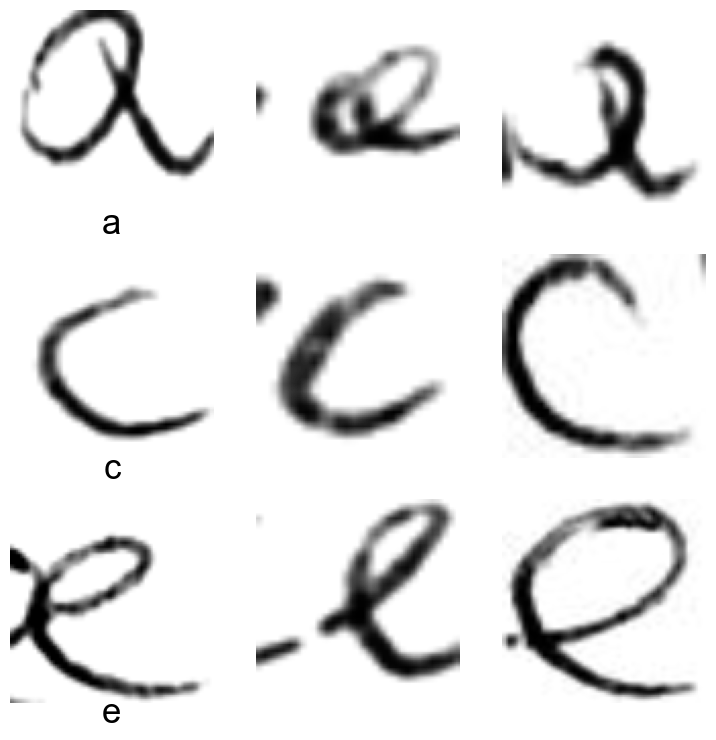

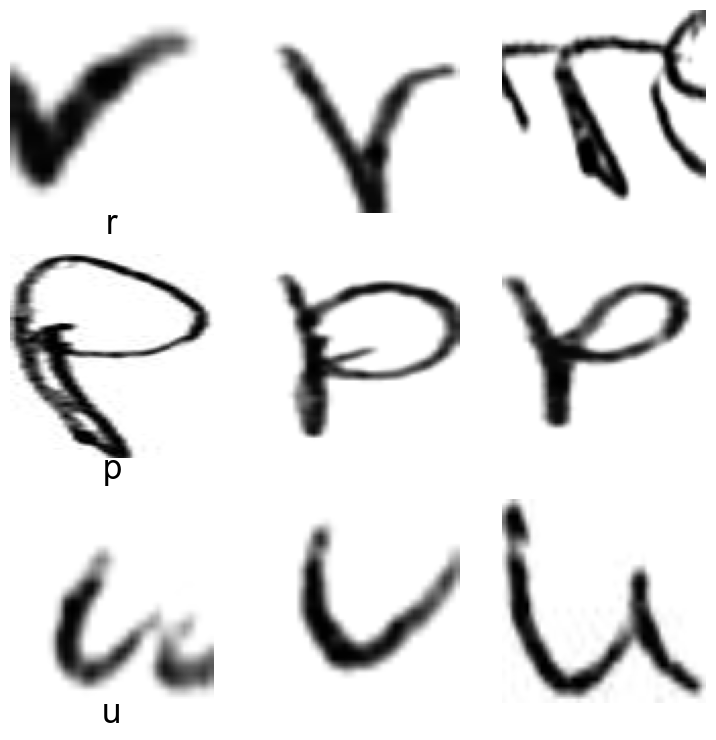

In [16]:
# Example usage
plot_sample_images(df_train, alphabet)
plot_sample_images(df_test, alphabet)

In [17]:
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(dataframe['label_int'].unique())}
        if self.augment:
            self.dataframe = pd.concat([dataframe, dataframe]).reset_index(drop=True)
        else:
            self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_array = row['image']
        if len(image_array.shape) == 3 and image_array.shape[2] == 1:
            image_array = image_array.squeeze(-1)  # Remove the channel dimension if it's 1
        image = Image.fromarray(image_array.astype(np.uint8)).convert('RGB')  # Convert to RGB
        label = row['label_int']

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ensure label_int column is present
df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))

# Split dataset into training, testing, and validation
train_df, test_val_df = train_test_split(df_train, test_size=0.4, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

train_dataset = CustomDataset(train_df, transform=train_transform, augment=True) # Augmentation duplicates size of training dataset
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print shapes of data from data loaders
def print_data_shapes(loader, dataset_name):
    print(f"{dataset_name} Samples ({len(loader.dataset)})")
    inputs, classes = next(iter(loader))
    print("Shape:", inputs.shape)
    print("-" * 40)

# Training data
print_data_shapes(train_loader, "Training")

# Validation data
print_data_shapes(val_loader, "Validation")

# Testing data
print_data_shapes(test_loader, "Testing")


Training Samples (2342)
Shape: torch.Size([64, 3, 50, 50])
----------------------------------------
Validation Samples (391)
Shape: torch.Size([64, 3, 50, 50])
----------------------------------------
Testing Samples (390)
Shape: torch.Size([64, 3, 50, 50])
----------------------------------------


In [18]:
import numpy as np
import torchvision

# Training data
print(f"Training Samples ({len(train_dataset)})")
inputs, classes = next(iter(train_loader))
print("Shape:", inputs.shape)

# Validation data
print(f"Validation Samples ({len(val_dataset)})")
inputs, classes = next(iter(val_loader))
print("Shape:", inputs.shape)

# Testing data
print(f"Testing Samples ({len(test_dataset)})")
inputs, classes = next(iter(test_loader))
print("Shape:", inputs.shape)

Training Samples (2342)
Shape: torch.Size([64, 3, 50, 50])
Validation Samples (391)
Shape: torch.Size([64, 3, 50, 50])
Testing Samples (390)
Shape: torch.Size([64, 3, 50, 50])


## Letter-Classifier model

In [19]:
class AverageValueMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.n = 0

    def add(self, value, n):
        self.sum += value * n
        self.n += n

    def value(self):
        return self.sum / self.n if self.n > 0 else 0

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

class LetterClassifier(nn.Module):
    
    def __init__(self, input_shape=(50, 50, 3), num_classes=25, dropout_rate=0.5):
        super(LetterClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # convolutional layer 1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # convolutional layer 2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # convolutional layer 3
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # convolutional layer 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512), # fully connected layer
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, num_classes) # output layer (fully connected)
        )

    def forward(self, x):
        return self.model(x)

    def numparams(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def train_model(self, train_loader, val_loader, exp_name='experiment', epochs=10, lr=0.001, momentum=0.9, weight_decay=1e-4, logdir='logs', verbose=True, save_model=True):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)  

        train_losses = []; train_accuracies = []
        val_losses = []; val_accuracies = []

        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        writer = SummaryWriter(join(logdir, exp_name))

        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") # usare cuda
        self.to(device)
        loader = {'train': train_loader, 'val': val_loader}

        global_step = 0
        best_val_loss = float('inf')
        epochs_no_improve = 0  
        patience = 10
        for e in range(epochs):
            print(f'[Epoch {e+1}/{epochs}]')
            for mode in ['train', 'val']:
                loss_meter.reset()
                acc_meter.reset()
                self.model.train() if mode == 'train' else self.model.eval()

                with torch.set_grad_enabled(mode == 'train'):
                    for i, batch in enumerate(loader[mode]):
                        X = batch[0].to(device)
                        y = batch[1].to(device)
                        out = self.model(X)

                        n = X.shape[0]
                        global_step += n
                        l = loss_fn(out, y)

                        if mode == 'train':
                            l.backward()
                            optimizer.step()
                            optimizer.zero_grad()

                        loss_meter.add(l.item(), n)
                        acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                        acc_meter.add(acc, n)

                        if mode == 'train':
                            writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                            writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)

                    writer.add_scalar('loss/'+mode, loss_meter.value(), global_step=global_step)
                    writer.add_scalar('accuracy/'+mode, acc_meter.value(), global_step=global_step)

                    if mode == 'train':
                        train_losses.append(loss_meter.value())
                        train_accuracies.append(acc_meter.value())
                    else:
                        val_losses.append(loss_meter.value())
                        val_accuracies.append(acc_meter.value())

                        if val_losses[-1] < best_val_loss:
                            best_val_loss = val_losses[-1]
                            epochs_no_improve = 0  
                            if save_model:
                                torch.save(self.model.state_dict(), os.path.join('models', f'{exp_name}.pth'))
                                with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
                                    pickle.dump({
                                        'train_loss': train_losses, 
                                        'val_loss': val_losses,
                                        'train_accuracy': train_accuracies, 
                                        'val_accuracy': val_accuracies
                                    }, f)
                        else:
                            epochs_no_improve += 1 

            if verbose:
                print(f'Train Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_accuracies[-1]:.3f} | Val Loss: {val_losses[-1]:.3f}, Val Accuracy: {val_accuracies[-1]:.3f}\n')

            if epochs_no_improve == patience:
                print('Early stopping')
                break

        return train_losses, train_accuracies, val_losses, val_accuracies

    def test_model(self, test_loader):
        self.model.eval()
        loss_fn = nn.CrossEntropyLoss()
        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)

        with torch.no_grad():
            for batch in test_loader:
                X = batch[0].to(device)
                y = batch[1].to(device)
                out = self.model(X)

                n = X.shape[0]
                l = loss_fn(out, y)

                loss_meter.add(l.item(), n)
                acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                acc_meter.add(acc, n)

        test_loss = loss_meter.value()
        test_accuracy = acc_meter.value()

        return test_loss, test_accuracy

    def test_error(self, test_loader):
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(device)
        predictions, labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device)
                y = batch[1].to(device)
                output = self.model(x)
                preds = output.to('cpu').max(1)[1].numpy()
                labs = y.to('cpu').numpy()
                predictions.extend(list(preds))
                labels.extend(list(labs))
        error = (1 - accuracy_score(np.array(labels), np.array(predictions))) * 100
        return error
    
    def evaluate(self, test_loader):
        self.model.eval()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        
        return precision, recall, f1
    
    def confusion_matrix(self, test_loader):
        self.model.eval()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        return confusion_matrix(all_labels, all_preds)
    
    def plot_precision_recall_curve(self, test_loader, file_path=None):
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.eval()
        self.to(device)
        
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        all_labels_bin = label_binarize(all_labels, classes=np.unique(all_labels))
        n_classes = all_labels_bin.shape[1]
        class_names = ["Rock", "Paper", "Scissors"]
        
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
            plt.plot(recall, precision, lw=2, label=f'class {class_names[i]}') 
            
            auc_score = auc(recall, precision)
            print(f'AUC per la classe {class_names[i]}: {auc_score:.3f}')  
        
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="best")
        plt.title("Precision-Recall curve")
        if file_path:
            plt.savefig(file_path)
        plt.show()

In [21]:
letter_classifier = LetterClassifier()
print(f'The model has {letter_classifier.numparams()} trainable parameters')

The model has 1582361 trainable parameters


## Train the model

In [22]:
lr = 0.001
momentum = 0.9
weight_decay = 0.0001
dropout_rate = 0.2

exp_name = 'letter_classifier_1'
epochs = 50

letter_classifier = LetterClassifier()
train_losses, train_accuracies, test_losses, test_accuracies = letter_classifier.train_model(train_loader,
                                                                                          val_loader,
                                                                                          exp_name=exp_name,
                                                                                          epochs=epochs,
                                                                                          lr=lr,
                                                                                          momentum=momentum,
                                                                                          weight_decay=weight_decay)


[Epoch 1/50]
Train Loss: 3.220, Train Accuracy: 0.058 | Val Loss: 3.156, Val Accuracy: 0.043

[Epoch 2/50]
Train Loss: 3.131, Train Accuracy: 0.072 | Val Loss: 3.140, Val Accuracy: 0.043

[Epoch 3/50]
Train Loss: 3.113, Train Accuracy: 0.065 | Val Loss: 3.136, Val Accuracy: 0.043

[Epoch 4/50]
Train Loss: 3.083, Train Accuracy: 0.075 | Val Loss: 3.128, Val Accuracy: 0.043

[Epoch 5/50]
Train Loss: 3.059, Train Accuracy: 0.078 | Val Loss: 3.124, Val Accuracy: 0.043

[Epoch 6/50]
Train Loss: 3.041, Train Accuracy: 0.087 | Val Loss: 3.121, Val Accuracy: 0.043

[Epoch 7/50]
Train Loss: 3.041, Train Accuracy: 0.085 | Val Loss: 3.117, Val Accuracy: 0.043

[Epoch 8/50]
Train Loss: 3.020, Train Accuracy: 0.099 | Val Loss: 3.111, Val Accuracy: 0.043

[Epoch 9/50]
Train Loss: 2.976, Train Accuracy: 0.120 | Val Loss: 3.115, Val Accuracy: 0.043

[Epoch 10/50]
Train Loss: 2.972, Train Accuracy: 0.115 | Val Loss: 3.115, Val Accuracy: 0.043

[Epoch 11/50]
Train Loss: 2.963, Train Accuracy: 0.120 | Va

## Test the model

In [23]:
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
letter_classifier.model.eval()

with torch.no_grad():
    test_loss, test_accuracy = letter_classifier.test_model(test_loader)

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

Test Loss: 2.701, Test Accuracy: 0.179


In [24]:
test_error = letter_classifier.test_error(test_loader)
print(f"Error percentage: {test_error:.2f} %")

Error percentage: 82.05 %


In [25]:
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

# Add the new metrics
metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_accuracy
metrics['test_error'] = test_error

# Save the updated metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

Metrics updated and saved successfully


## After model selection 

In [27]:
# Load the model
letter_classifier = LetterClassifier()
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
print("Model loaded successfully")

# Load metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

# Convert the metrics to float and round to 3 decimal places
train_losses = [round(float(i), 3) for i in metrics['train_loss']]
val_losses = [round(float(i), 3) for i in metrics['val_loss']]
train_accuracies = [round(float(i), 3) for i in metrics['train_accuracy']]
val_accuracies = [round(float(i), 3) for i in metrics['val_accuracy']]
test_loss = round(float(metrics['test_loss']), 3)
test_accuracy = round(float(metrics['test_accuracy']), 3)
test_error = round(float(metrics['test_error']), 2)

print(f"Best epoch: {len(val_losses)}/{epochs}\n")
print(f"Train Loss: {train_losses[-1]}")
print(f"Train Accuracy: {train_accuracies[-1]}\n")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Validation Accuracy: {val_accuracies[-1]}\n")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Error: {test_error}%")

Model loaded successfully
Metrics loaded successfully

Best epoch: 50/50

Train Loss: 2.605
Train Accuracy: 0.227

Validation Loss: 2.753
Validation Accuracy: 0.159

Test Loss: 2.701
Test Accuracy: 0.179
Test Error: 82.05%


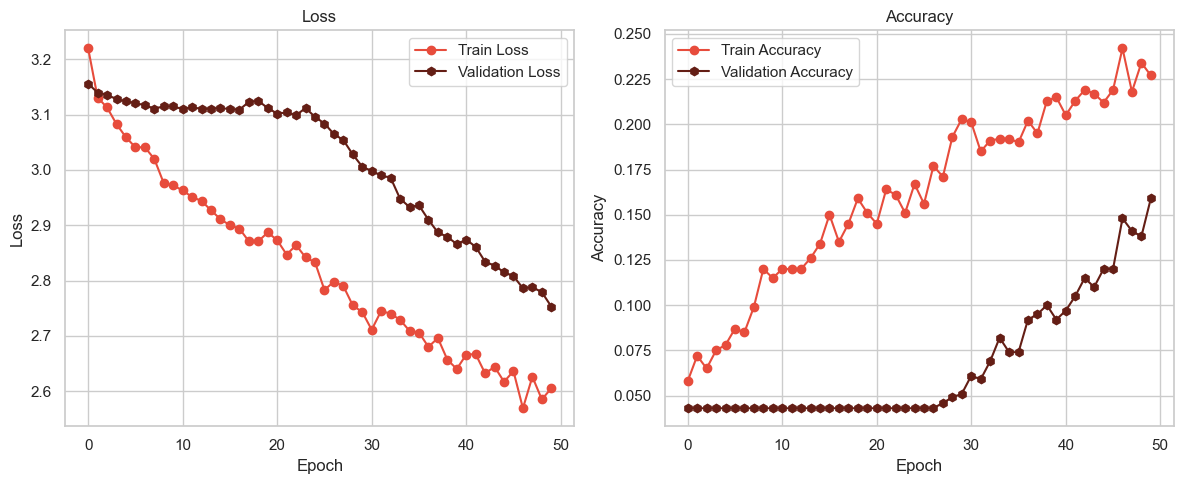

In [28]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(val_losses, color="#641E15", label='Validation Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, color="#641E15", label='Validation Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, f'plots/{exp_name}_accuracy_and_Loss.png')

In [29]:
precision, recall, f1 = letter_classifier.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.171
Recall: 0.138
F1 Score: 0.107


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


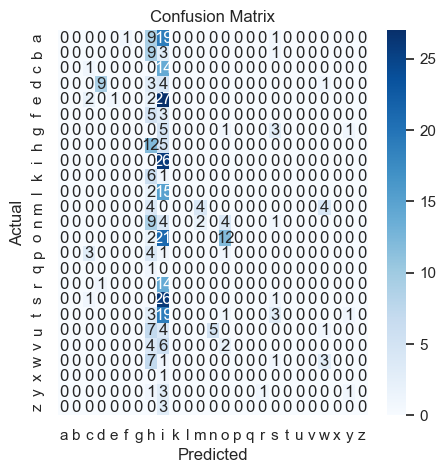

In [31]:
def print_confusion_matrix(conf_matrix, class_names, file_path=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    if file_path:
        plt.savefig(file_path)
    plt.show()

cm = letter_classifier.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

AUC per la classe Rock: 0.083
AUC per la classe Paper: 0.026
AUC per la classe Scissors: 0.049


IndexError: list index out of range

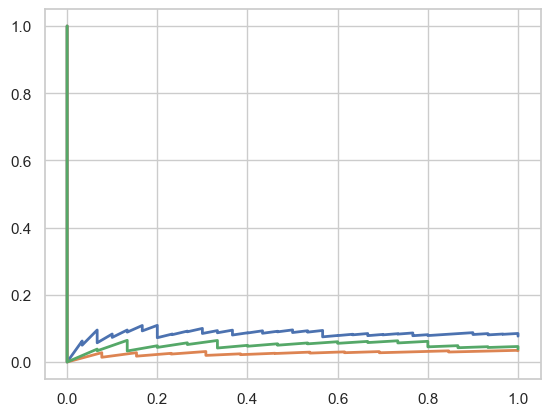

In [32]:
letter_classifier.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')
# la classe Scissors infatti ha una performance peggiore rispetto alle altre due classi.

## Comparison with Noted Models in the Literature

In [42]:
from torchvision.models import alexnet, vgg16, googlenet, resnet18, squeezenet1_0, AlexNet_Weights, VGG16_Weights, GoogLeNet_Weights, ResNet18_Weights, SqueezeNet1_0_Weights

class GenericModel(LetterClassifier):

    def __init__(self, model_architecture, num_classes=25):
        super(GenericModel, self).__init__(num_classes=num_classes)  
        self.model = self.get_model(model_architecture, num_classes)
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  
        self.model.to(self.device)

    def get_model(self, model_architecture, num_classes):
        if model_architecture == 'alexnet':
            model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'vgg':
            model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'googlenet':
            model = googlenet(weights=GoogLeNet_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_architecture == 'resnet':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_architecture == 'squeezenet':
            model = squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT)
            model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        else:
            raise ValueError(f"Model architecture '{model_architecture}' not recognized")
        return model

## Reload datasets

In [39]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split dataset into training, testing, and validation
train_df = df_train
test_df, val_df = train_test_split(df_test, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_df, transform=train_transform, augment=False) 
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## AlexNet

In [43]:
alexnet = GenericModel('alexnet')
print(f'The model has {alexnet.numparams()} trainable parameters')

The model has 57106265 trainable parameters


In [44]:
alexnet.eval()
with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)
    
print('\nNon fine-tuned AlexNet:')
print(f'Test Loss: {alexnet_test_loss:.3f}, Test Accuracy: {alexnet_test_accuracy:.3f}')


Non fine-tuned AlexNet:
Test Loss: 3.530, Test Accuracy: 0.010


In [46]:
lr = 0.0001 
momentum = 0.9
weight_decay = 0.01 
exp_name = 'alexnet_experiment'

alexnet_train_losses, alexnet_train_accuracies, alexnet_val_losses, alexnet_val_accuracies = alexnet.train_model(train_loader, 
                                                                                                                 val_loader,
                                                                                                                 exp_name=exp_name, 
                                                                                                                 epochs=10,
                                                                                                                 lr=lr,
                                                                                                                 momentum=momentum,
                                                                                                                 weight_decay=weight_decay)

[Epoch 1/10]
Train Loss: 3.108, Train Accuracy: 0.070 | Val Loss: 3.129, Val Accuracy: 0.082

[Epoch 2/10]
Train Loss: 2.996, Train Accuracy: 0.109 | Val Loss: 3.008, Val Accuracy: 0.153

[Epoch 3/10]
Train Loss: 2.920, Train Accuracy: 0.142 | Val Loss: 2.916, Val Accuracy: 0.184

[Epoch 4/10]
Train Loss: 2.829, Train Accuracy: 0.173 | Val Loss: 2.817, Val Accuracy: 0.173

[Epoch 5/10]
Train Loss: 2.762, Train Accuracy: 0.200 | Val Loss: 2.712, Val Accuracy: 0.245

[Epoch 6/10]
Train Loss: 2.656, Train Accuracy: 0.222 | Val Loss: 2.572, Val Accuracy: 0.327

[Epoch 7/10]
Train Loss: 2.625, Train Accuracy: 0.227 | Val Loss: 2.499, Val Accuracy: 0.286

[Epoch 8/10]
Train Loss: 2.563, Train Accuracy: 0.236 | Val Loss: 2.422, Val Accuracy: 0.276

[Epoch 9/10]
Train Loss: 2.492, Train Accuracy: 0.269 | Val Loss: 2.251, Val Accuracy: 0.327

[Epoch 10/10]
Train Loss: 2.448, Train Accuracy: 0.285 | Val Loss: 2.192, Val Accuracy: 0.347



In [53]:
exp_name = 'alexnet_experiment'
alexnet.eval()

with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)
    
test_error = alexnet.test_error(test_loader)

with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_accuracy
metrics['test_error'] = test_error

with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
alexnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned AlexNet:')
print(f"Train Loss: {round(float(metrics['train_loss']), 3)}")
print(f"Train Accuracy: {round(float(metrics['train_accuracy']), 3)}\n")
print(f"Validation Loss: {round(float(metrics['val_loss']), 3)}")
print(f"Validation Accuracy: {round(float(metrics['val_accuracy']), 3)}\n")
print(f"Test Loss: {round(float(metrics['test_loss']), 3)}")
print(f"Test Accuracy: {round(float(metrics['test_accuracy']), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned AlexNet:


TypeError: float() argument must be a string or a real number, not 'list'

Precision: 0.622
Recall: 0.646
F1 Score: 0.586


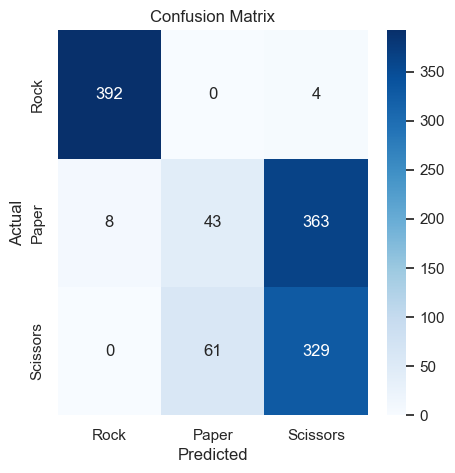

AUC per la classe Rock: 0.998
AUC per la classe Paper: 0.536
AUC per la classe Scissors: 0.608


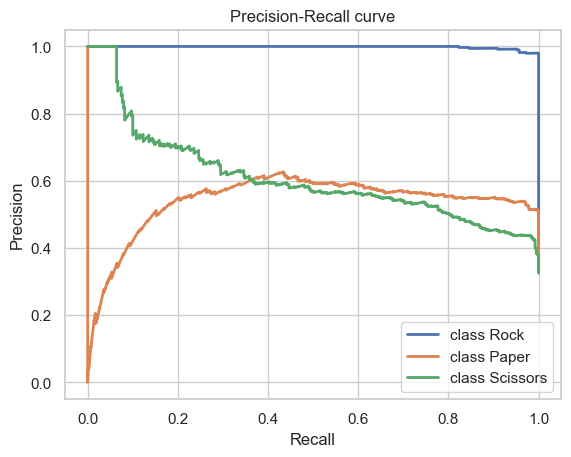

In [ ]:
precision, recall, f1 = alexnet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = alexnet.confusion_matrix(test_loader) 
class_names = ['Rock', 'Paper', 'Scissors']  

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

alexnet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## VGG

In [ ]:
vgg = GenericModel('vgg')
print(f'The model has {vgg.numparams()} trainable parameters')

The model has 134272835 trainable parameters


## GoogleNet

In [ ]:
googlenet = GenericModel('googlenet')
print(f'The model has {googlenet.numparams()} trainable parameters')

The model has 5602979 trainable parameters


In [ ]:
googlenet.eval()
with torch.no_grad():
    googlenet_test_loss, googlenet_test_accuracy = googlenet.test_model(test_loader)
    
print('\nNon fine-tuned GoogleNet:')
print(f'Test Loss: {googlenet_test_loss:.3f}, Test Accuracy: {googlenet_test_accuracy:.3f}')


Non fine-tuned GoogleNet:
Test Loss: 1.122, Test Accuracy: 0.268


In [ ]:
exp_name = 'googlenet_experiment'

'''
googlenet_train_losses, googlenet_train_accuracies, googlenet_val_losses, googlenet_val_accuracies = googlenet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=10,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

'\ngooglenet_train_losses, googlenet_train_accuracies, googlenet_val_losses, googlenet_val_accuracies = googlenet.train_model(train_loader, \n                                                                                             val_loader,\n                                                                                             exp_name=exp_name, \n                                                                                             epochs=10,\n                                                                                             lr=lr,\n                                                                                             momentum=momentum,\n                                                                                             weight_decay=weight_decay)\n'

In [ ]:
exp_name = 'googlenet_experiment'
googlenet.eval()

with torch.no_grad():
    googlenet_test_loss, googlenet_test_accuracy = googlenet.test_model(test_loader)
    
test_error = googlenet.test_error(test_loader)

with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_accuracy
metrics['test_error'] = test_error

with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
googlenet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned GoogleNet:')
print(f"Train Loss: {round(float(metrics['train_loss']), 3)}")
print(f"Train Accuracy: {round(float(metrics['train_accuracy']), 3)}\n")
print(f"Validation Loss: {round(float(metrics['val_loss']), 3)}")
print(f"Validation Accuracy: {round(float(metrics['val_accuracy']), 3)}\n")
print(f"Test Loss: {round(float(metrics['test_loss']), 3)}")
print(f"Test Accuracy: {round(float(metrics['test_accuracy']), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned GoogleNet:
Train Loss: 0.512
Train Accuracy: 0.797

Validation Loss: 2.009
Validation Accuracy: 0.09

Test Loss: 0.526
Test Accuracy: 0.845


Precision: 0.771
Recall: 0.641
F1 Score: 0.623


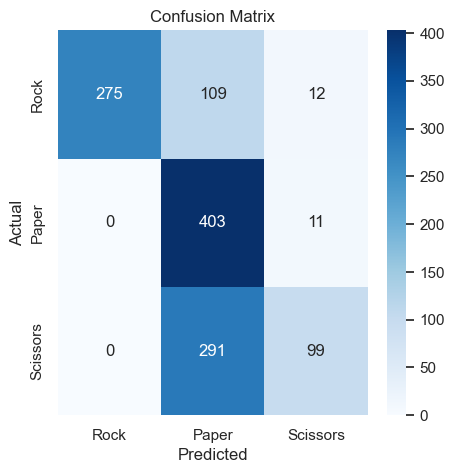

AUC per la classe Rock: 0.998
AUC per la classe Paper: 0.937
AUC per la classe Scissors: 0.770


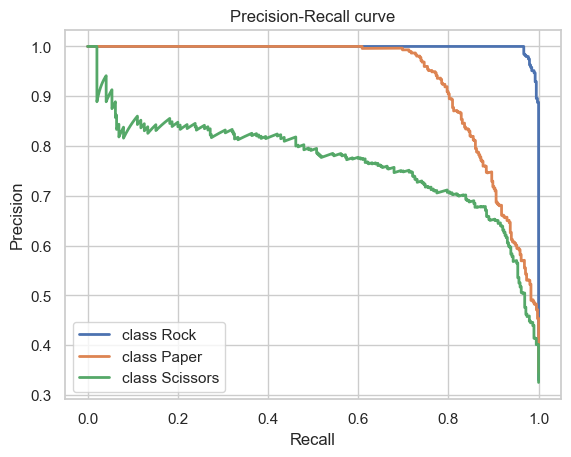

In [ ]:
precision, recall, f1 = googlenet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = googlenet.confusion_matrix(test_loader) 
class_names = ['Rock', 'Paper', 'Scissors']  

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

googlenet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## ResNet

In [ ]:
resnet = GenericModel('resnet')
print(f'The model has {resnet.numparams()} trainable parameters')

The model has 11178051 trainable parameters


## SqueezeNet

In [ ]:
squeezenet = GenericModel('squeezenet')
print(f'The model has {squeezenet.numparams()} trainable parameters')

The model has 736963 trainable parameters


In [ ]:
squeezenet.eval()
with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)
    
print('\nNon fine-tuned SqueezeNet:')
print(f'Test Loss: {squeezenet_test_loss:.3f}, Test Accuracy: {squeezenet_test_accuracy:.3f}')


Non fine-tuned SqueezeNet:
Test Loss: 1.451, Test Accuracy: 0.203


In [ ]:
lr = 0.001 
momentum = 0.9
weight_decay = 0.001 
exp_name = 'squeezenet_experiment'

'''
squeezenet_train_losses, squeezenet_train_accuracies, squeezenet_val_losses, squeezenet_val_accuracies = squeezenet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=10,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

'\nsqueezenet_train_losses, squeezenet_train_accuracies, squeezenet_val_losses, squeezenet_val_accuracies = squeezenet.train_model(train_loader, \n                                                                                             val_loader,\n                                                                                             exp_name=exp_name, \n                                                                                             epochs=10,\n                                                                                             lr=lr,\n                                                                                             momentum=momentum,\n                                                                                             weight_decay=weight_decay)\n'

In [ ]:
exp_name = 'squeezenet_experiment'
squeezenet.eval()

with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)
    
test_error = squeezenet.test_error(test_loader)

with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_accuracy
metrics['test_error'] = test_error

with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
squeezenet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned SqueezeNet:')
print(f"Train Loss: {round(float(metrics['train_loss']), 3)}")
print(f"Train Accuracy: {round(float(metrics['train_accuracy']), 3)}\n")
print(f"Validation Loss: {round(float(metrics['val_loss']), 3)}")
print(f"Validation Accuracy: {round(float(metrics['val_accuracy']), 3)}\n")
print(f"Test Loss: {round(float(metrics['test_loss']), 3)}")
print(f"Test Accuracy: {round(float(metrics['test_accuracy']), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned SqueezeNet:
Train Loss: 0.679
Train Accuracy: 0.701

Validation Loss: 4.505
Validation Accuracy: 0.04

Test Loss: 0.526
Test Accuracy: 0.845


Precision: 0.849
Recall: 0.832
F1 Score: 0.835


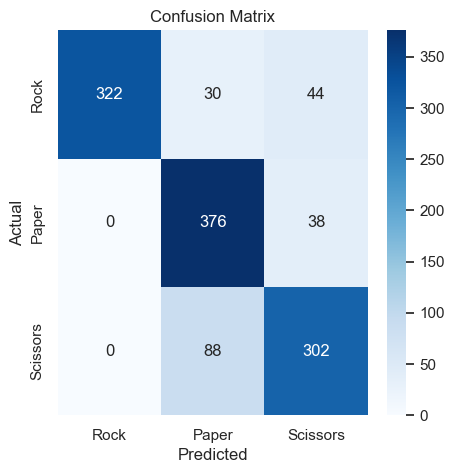

AUC per la classe Rock: 1.000
AUC per la classe Paper: 0.952
AUC per la classe Scissors: 0.851


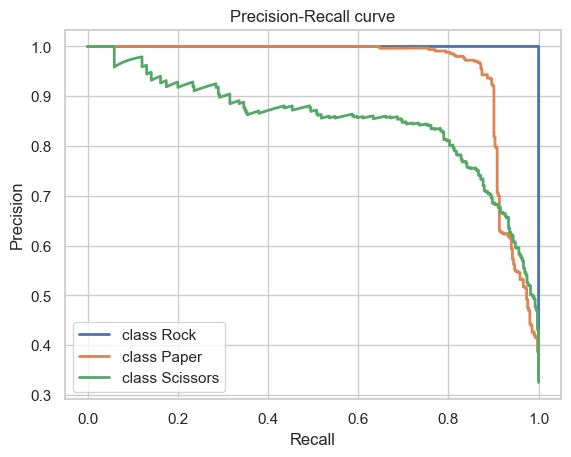

In [ ]:
precision, recall, f1 = squeezenet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = squeezenet.confusion_matrix(test_loader) 
class_names = ['Rock', 'Paper', 'Scissors']  

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

squeezenet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')